In [41]:
import random

import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
%load_ext line_profiler

PIL2torch = transforms.ToTensor()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [42]:
class FaceFolderDataset(Dataset):
    def __init__(self, root_dir, dirs=None, image_size=(112, 112)):
        self.image_size = image_size
        self.root_dir = root_dir
        self.persons = sorted(os.listdir(root_dir))
        if dirs is not None:
            for p in self.persons:
                if p not in dirs:
                    self.persons.remove(p)
        self.person_images = {p: [] for p in self.persons}
        self.image_paths = []

        self.images_per_person = None
        for i, per in enumerate(self.persons):
            pearson_dir = self.person_dir(per)
            if self.images_per_person is None:
                self.images_per_person = len(os.listdir(pearson_dir))
            else:
                if self.images_per_person != len(os.listdir(pearson_dir)):
                    warnings.warn(f"Person {per} has different number of images than other persons")
            for file_name in os.listdir(pearson_dir):
                self.image_paths.append(os.path.join(pearson_dir, file_name))
                self.person_images[per].append(file_name)


    def person_dir(self, person: str)->str:
        if person in self.persons:
            return os.path.join(self.root_dir, person)
        else:
            raise ValueError(f"Person {person} not found in dataset")

    def __len__(self)->int:
        return len(self.image_paths)

    def __getitem__(self, idx: tuple[str, int] | str)->(Image.Image, str):
        """
        :param idx: tuple of (person, image_idx) of person images or person: str - to get random person image
        :return:
        """
        if type(idx) is tuple:
            person, id_ = idx
            image_path = os.path.join(self.root_dir, person,  self.person_images[person][id_])
            img = Image.open(image_path)
            img = img.convert("RGB")
            return img, person
        elif type(idx) is str or type(idx) is np.str_:
            person = idx
            image_path = os.path.join(self.root_dir, person, random.choice(self.person_images[person]))

            img = Image.open(image_path)
            img = img.convert("RGB")
            return img, person
        else:
            raise ValueError(f"idx must be tuple of (person, image_idx) or str, but got {type(idx)}")

In [43]:
class FaceDataLoader:
    def __init__(self, dataset, batch_size=32, number_of_batches=1000):
        self.dataset = dataset
        self.batch_size = batch_size
        self.number_of_batches = number_of_batches

    def __iter__(self)->torch.Tensor:
        for _ in range(self.number_of_batches):
            result = torch.Tensor(3 * self.batch_size, 3, *self.dataset.image_size)
            persons = np.array(random.sample(self.dataset.persons, 2 * self.batch_size)).reshape(-1, 2)
            for i in range(0, 3 * self.batch_size, 3):
                result[i] = PIL2torch(self.dataset[persons[i//3, 0]][0])
                result[i+1] = PIL2torch(self.dataset[persons[i//3, 0]][0])
                result[i+2] = PIL2torch(self.dataset[persons[i//3, 1]][0])
            yield result


    def __len__(self):
        return self.number_of_batches

In [44]:
test_dataset = FaceFolderDataset(root_dir="images", dirs=[str(i) for i in range(0, 50)])
train_dataset  = FaceFolderDataset(root_dir="images", dirs=[str(i) for i in range(50, 5999)])

test_dataloader = FaceDataLoader(test_dataset, batch_size=16)
train_dataloader = FaceDataLoader(train_dataset, batch_size=124)

torch.Size([3, 112, 112]) torch.Size([3, 112, 112]) torch.Size([3, 112, 112])


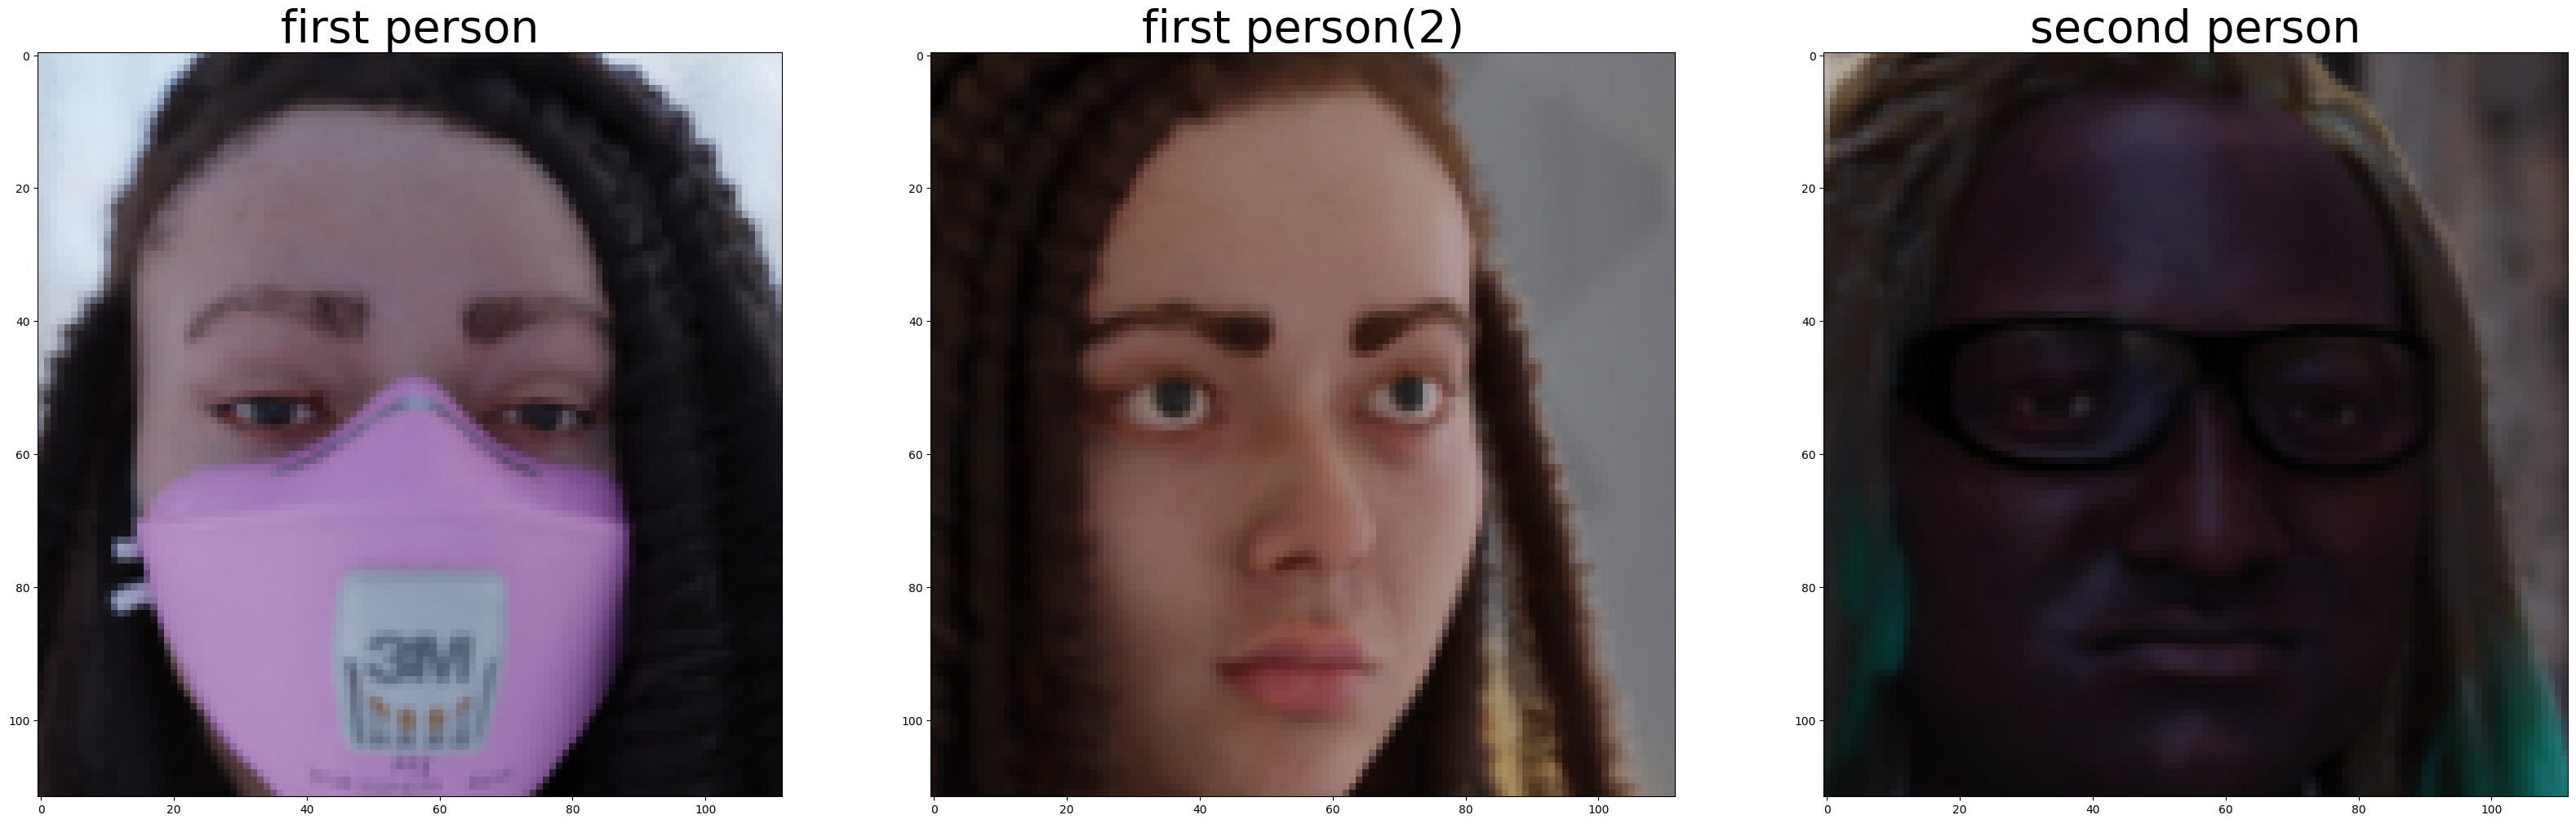

In [45]:
batch = next(iter(test_dataloader))
im11, im12, im21 = batch[:3]
print(im11.shape, im12.shape, im21.shape)
# for im11, im12, im21 in batch:
fig = plt.figure(figsize=(40, 40))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im11.permute(1, 2, 0).numpy())
ax1.set_title("first person")
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(im12.permute(1, 2, 0).numpy())
ax2.set_title("first person(2)")
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(im21.permute(1, 2, 0).numpy())
ax3.set_title("second person")

for ax in fig.axes:
    ax.title.set_fontsize(40)
plt.show()

In [46]:
_model = nn.Sequential( # Input image size = 112 x 112
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # Output image size = 56 x 56

    nn.Dropout(0.1),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # Output image size = 28 x 28

    nn.Dropout(0.1),
    nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1),
    nn.BatchNorm2d(48),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # Output image size = 14 x 14

    nn.Dropout(0.1),
    nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # Output image size = 7 x 7,

    nn.Dropout(0.2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(128 * 7 * 7, 1024),
    nn.Dropout(0.1),
    nn.BatchNorm1d(1024),
    nn.ReLU(),

    nn.Linear(1024, 256),
    nn.Dropout(0.2),
    nn.BatchNorm1d(256),
    nn.ReLU(),

    nn.Linear(256, 128),
    nn.BatchNorm1d(128)
)
device = torch.device('cuda')
model = _model.to(device)
# stupid_model = _model.to(device)


In [47]:
# Use torchsummary to check model memory usage
import torchsummary as ts
ts.summary(model, (3, 112, 112), batch_size=64 * 3, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [192, 32, 112, 112]             896
       BatchNorm2d-2        [192, 32, 112, 112]              64
              ReLU-3        [192, 32, 112, 112]               0
         MaxPool2d-4          [192, 32, 56, 56]               0
           Dropout-5          [192, 32, 56, 56]               0
            Conv2d-6          [192, 32, 56, 56]           9,248
       BatchNorm2d-7          [192, 32, 56, 56]              64
              ReLU-8          [192, 32, 56, 56]               0
         MaxPool2d-9          [192, 32, 28, 28]               0
          Dropout-10          [192, 32, 28, 28]               0
           Conv2d-11          [192, 48, 28, 28]          13,872
      BatchNorm2d-12          [192, 48, 28, 28]              96
             ReLU-13          [192, 48, 28, 28]               0
        MaxPool2d-14          [192, 48,

In [22]:
# load pretrained model norelu_model_70.pth
model.load_state_dict(torch.load("norelu_model_70.pth"))

<All keys matched successfully>

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
class Logger:
    def __init__(self):
        self.losses = []
        self.sim_losses = []
        self.diff_losses = []

    def log_loss(self, loss: torch.Tensor, sim_loss: torch.Tensor, diff_loss: torch.Tensor):
        self.losses.append(loss.item())
        self.sim_losses.append(sim_loss.item())
        self.diff_losses.append(diff_loss.item())

    def get_avg_loss(self, n:int = 1000):
        """"""
        return np.mean(self.losses[-n:]), np.mean(self.sim_losses[-n:]), np.mean(self.diff_losses[-n:])


In [51]:
vec1 = torch.Tensor([1, 2, -1])
vec2 = torch.Tensor([1, 2, -1.1])
vec3 = torch.Tensor([-10, 17, 1])
vecs = [vec1, vec2, vec3]
for i, vec in enumerate(vecs):
    vecs[i] = vec / torch.norm(vec)
vec1, vec2, vec3 = vecs
print(torch.cosine_similarity(vec1, vec2, dim=0), torch.cosine_similarity(vec1, vec3, dim=0))
print(torch.cosine_similarity(torch.stack((vec2, vec1)), torch.stack((vec1, vec3)), dim=1))
torch.stack((vec1, vec2))

tensor(0.9993) tensor(0.4755)
tensor([0.9993, 0.4755])


tensor([[ 0.4082,  0.8165, -0.4082],
        [ 0.4013,  0.8026, -0.4414]])

In [52]:
def loss_fn(vec_sim1: torch.Tensor, vec_sim2: torch.Tensor, vel_dif1: torch.Tensor, alpha: float =2, beta: float =1, logger: Logger = None)->torch.Tensor:
    """
    :param vec_sim1: vector, related to first image of first person
    :param vec_sim2: vector related to second image of first person
    :param vel_dif1: vector related to first image of second person
    :param alpha: similarity coefficient
    :param beta: difference coefficient
    :param logger: Logger object
    :return: torch.Tensor - total Loss
    """
    sim = alpha * ( 1 - torch.abs(torch.cosine_similarity(vec_sim1, vec_sim2, dim=1).mean()))
    dif = beta * torch.abs(torch.cosine_similarity(vec_sim1, vel_dif1, dim=1).mean() + torch.cosine_similarity(vec_sim2, vel_dif1, dim=1).mean())
    total_loss = sim + dif
    if logger is not None:
        logger.log_loss(total_loss, sim, dif)
    return total_loss

In [53]:
logger = Logger()
test_logger = Logger()

In [54]:
def train(N):
    for epoch in tqdm(range(N)):
        for i, batch in enumerate(tqdm(train_dataloader, colour="green")):
            model.train()
            batch = batch.to(device)
            vec = model(batch)
            torch.nn.functional.normalize(vec)
            sim1 = vec[::3]
            sim2 = vec[1::3]
            dif1 = vec[2::3]
            # if i % 100 == 0:
            #     logger_ = logger
            # else:
            #     logger_ = None
            loss = loss_fn(sim1, sim2, dif1, logger=logger)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for el in tqdm(test_dataloader, colour="red"):
                el = el.to(device)
                vec = model(el)
                sim1 = vec[::3]
                sim2 = vec[1::3]
                dif1 = vec[2::3]
                _ = loss_fn(sim1, sim2, dif1, logger=test_logger)

        if epoch % 35 == 0:
            torch.save(model.state_dict(), f"norelu_model_{epoch}.pth")
        model.train()

        print(f"Epoch {epoch} test loss: {test_logger.get_avg_loss()} train loss {logger.get_avg_loss()}")

In [ ]:
train(150)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 test loss: (1.009329682394862, 0.7060875566005707, 0.3032421261128038) train loss (0.9749881516993045, 0.8438778669834137, 0.1311102839943487)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

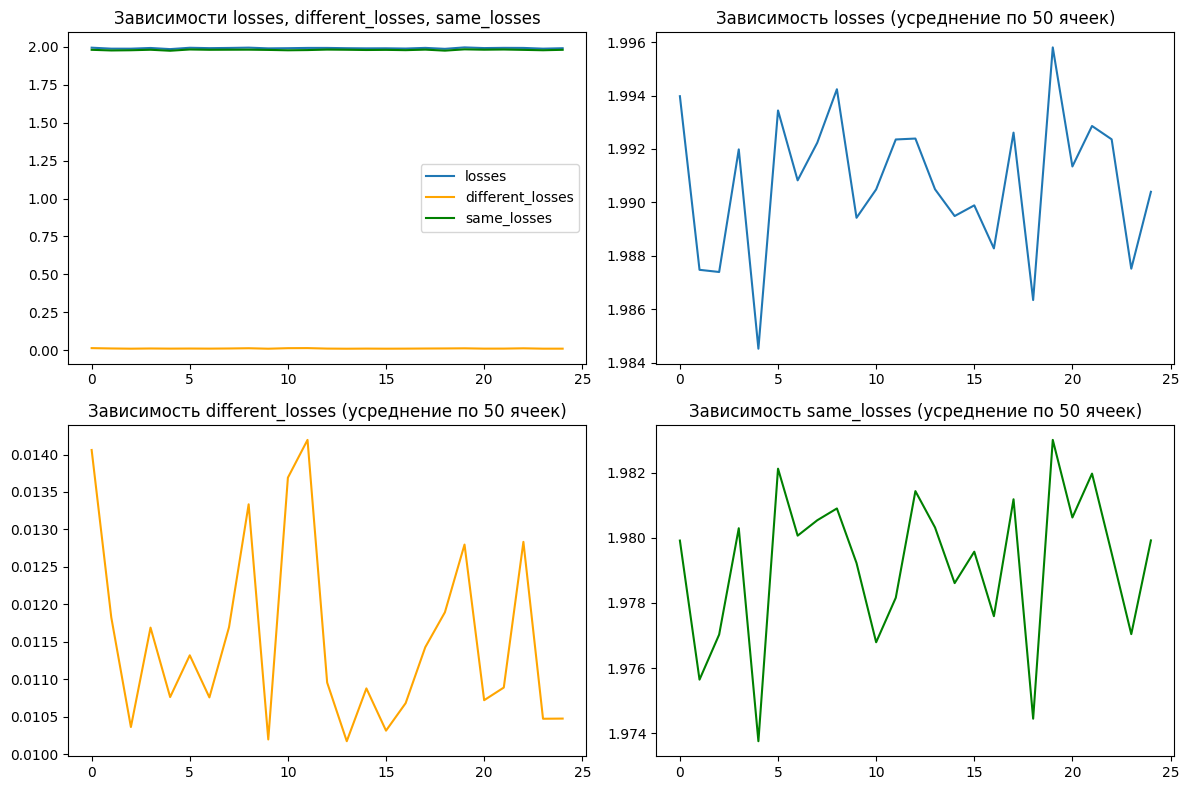

In [40]:
# Графики для трэин лоса
# Усредняем каждые 50 ячеек
losses, different_losses, same_losses = logger.losses, logger.diff_losses, logger.sim_losses
N = len(losses)
avgk = 40
losses_avg = [np.mean(losses[i:i+avgk]) for i in range(0, N, avgk)]
different_losses_avg = [np.mean(different_losses[i:i+avgk]) for i in range(0, N, avgk)]
same_losses_avg = [np.mean(same_losses[i:i+avgk]) for i in range(0, N, avgk)]

# Создаем фигуру и оси графиков
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Зависимости losses, differ
# ent_losses, same_losses от индекса на одном графике
axs[0, 0].plot(losses_avg, label='losses')
axs[0, 0].plot(different_losses_avg, color='orange', label='different_losses')
axs[0, 0].plot(same_losses_avg, color='green', label='same_losses')
axs[0, 0].set_title('Зависимости losses, different_losses, same_losses')
axs[0, 0].legend()

# Зависимость losses от индекса
axs[0, 1].plot(losses_avg)
axs[0, 1].set_title('Зависимость losses (усреднение по 50 ячеек)')

# Зависимость different_losses от индекса
axs[1, 0].plot(different_losses_avg, color='orange')
axs[1, 0].set_title('Зависимость different_losses (усреднение по 50 ячеек)')

# Зависимость same_losses от индекса
axs[1, 1].plot(same_losses_avg, color='green')
axs[1, 1].set_title('Зависимость same_losses (усреднение по 50 ячеек)')

# Отображаем графики
plt.tight_layout()
plt.show()

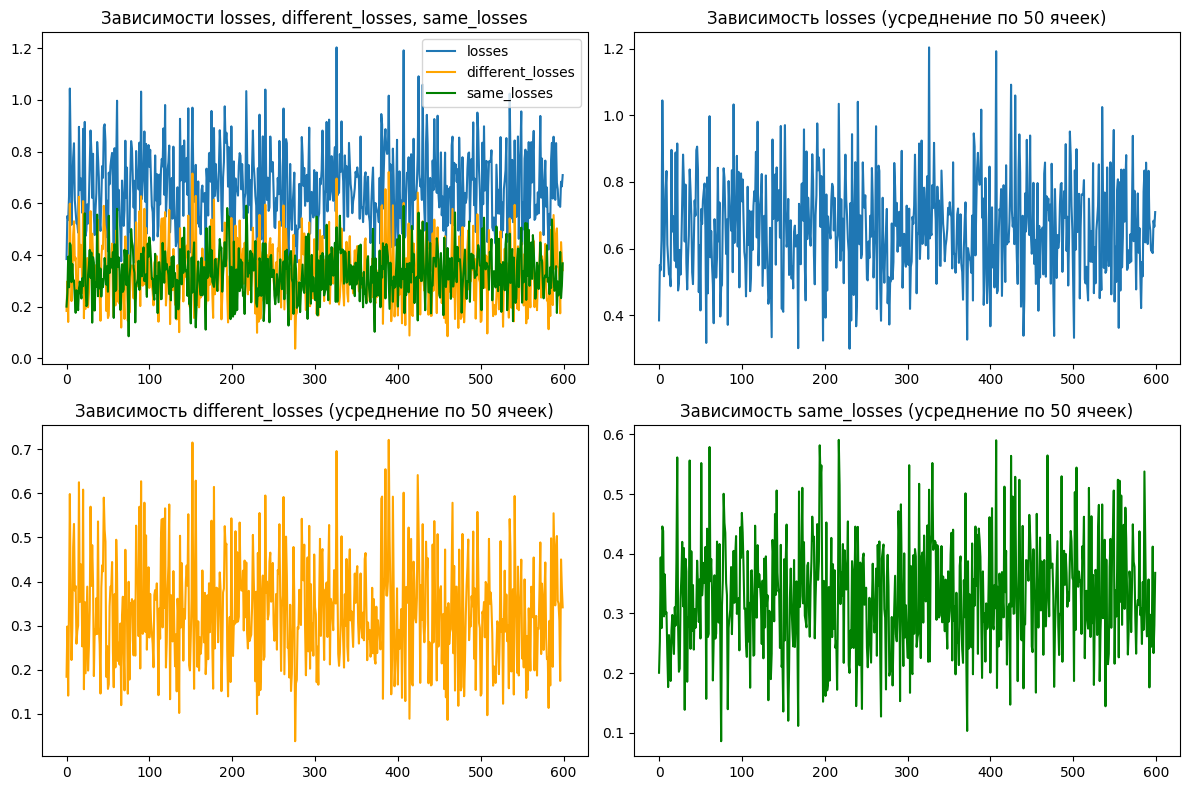

In [32]:
# Грифи для тест лоса
# Усредняем каждые 50 ячеек
losses, different_losses, same_losses = test_logger.losses, test_logger.diff_losses, test_logger.sim_losses
N = len(losses)
avgk = 5
losses_avg = [np.mean(losses[i:i+avgk]) for i in range(0, N, avgk)]
different_losses_avg = [np.mean(different_losses[i:i+avgk]) for i in range(0, N, avgk)]
same_losses_avg = [np.mean(same_losses[i:i+avgk]) for i in range(0, N, avgk)]

# Создаем фигуру и оси графиков
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Зависимости losses, differ
# ent_losses, same_losses от индекса на одном графике
axs[0, 0].plot(losses_avg, label='losses')
axs[0, 0].plot(different_losses_avg, color='orange', label='different_losses')
axs[0, 0].plot(same_losses_avg, color='green', label='same_losses')
axs[0, 0].set_title('Зависимости losses, different_losses, same_losses')
axs[0, 0].legend()

# Зависимость losses от индекса
axs[0, 1].plot(losses_avg)
axs[0, 1].set_title('Зависимость losses (усреднение по 50 ячеек)')

# Зависимость different_losses от индекса
axs[1, 0].plot(different_losses_avg, color='orange')
axs[1, 0].set_title('Зависимость different_losses (усреднение по 50 ячеек)')

# Зависимость same_losses от индекса
axs[1, 1].plot(same_losses_avg, color='green')
axs[1, 1].set_title('Зависимость same_losses (усреднение по 50 ячеек)')

# Отображаем графики
plt.tight_layout()
plt.show()

In [ ]:
# torch.save(model.state_dict(), "weights_77_no_relu_norm.pth")

# Data validating


In [116]:
class ValidationDataset(Dataset):
    def __init__(self, root_dir: str, n_train: int =4, image_size: (int, int) = (112, 112), limit_persons=None):
        self.root_dir = root_dir
        self.n_train = n_train

        persons = os.listdir(root_dir)
        self.images_per_person = None
        images = []
        for person in tqdm(persons):
            if limit_persons is not None and limit_persons(person):
                continue
            for image in os.listdir(os.path.join(root_dir, person)):
                images.append({
                    "dir": os.path.join(root_dir, person, image),
                    "person_label": person,
                    "vector": None,
                    "type": "data" if int(image.replace(".png", "")) <= n_train - 1 else "validation"
                })
                if self.images_per_person is None:
                    self.images_per_person = len(os.listdir(os.path.join(root_dir, person)))
        self.data = pd.DataFrame(images)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data.iloc[idx], PIL2torch(Image.open(self.data.iloc[idx]["dir"]).convert("RGB"))

    def set_vector(self, ids :list[int], vector: torch.Tensor):
        for i, id in enumerate(ids):
            self.data.loc[id].at["vector"] = vector[i]

def limit(person:str):
    try:
        return int(person) > 103009
    except ValueError:
        warnings.warn(f"Person {person} is not a number")
        return True
dataset_trained = ValidationDataset("validation", limit_persons=limit)
dataset_untrained = ValidationDataset("validation", limit_persons=limit)

  0%|          | 0/32881 [00:00<?, ?it/s]

  0%|          | 0/32881 [00:00<?, ?it/s]

In [ ]:
dataset_trained.data["person_label"].unique()

In [ ]:
def fit(model, dataset):
    model.eval()
    with torch.no_grad():
        for i, (data, image) in enumerate(tqdm(dataset)):
            image = image.to(device)
            # Add batch dim to image
            image = image.unsqueeze(0)
            vector = model(image).to("cpu")
            dataset.set_vector([i], vector)
fit(stupid_model, dataset_untrained)
fit(model, dataset_trained)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
for i, dataset in enumerate([dataset_untrained, dataset_trained]):
    X_base = torch.stack(dataset.data[dataset.data["type"] == "data"]["vector"].tolist())
    Y_base = dataset.data[dataset.data["type"] == "data"]["person_label"].to_numpy()
    if i == 0:
        neigh_untrained = KNeighborsClassifier(n_neighbors=3)
        neigh_untrained.fit(X_base, Y_base)
        Y_base_untrained = Y_base
    else:
        neight_trained = KNeighborsClassifier(n_neighbors=3)
        neight_trained.fit(X_base, Y_base)
        Y_base_trained = Y_base

In [ ]:
def getX(datasets, neights):
    for dataset, neigh in zip(datasets, neights):
        X = torch.stack(dataset.data[dataset.data["type"] == "validation"]["vector"].tolist())
        Y = neigh.predict(X)
        Y_excepted = dataset.data[dataset.data["type"] == "validation"]["person_label"].to_numpy()
        yield X, Y, Y_excepted
XY_trained, XY_untrained = getX([dataset_untrained, dataset_trained], [neigh_untrained, neight_trained])
X_trained, Y_trained, Y_excepted_trained, X_untrained, Y_untrained, Y_excepted_untrained = *XY_trained, *XY_untrained

In [ ]:

alphas = np.linspace(0.001, 0.999, 7)
res_trained = []
res_untrained = []
for alpha in alphas:
    neighbours_objects_untrained = neigh_untrained.kneighbors(X_untrained, n_neighbors=int(alpha*len(Y_untrained)), return_distance=False)
    neighbours_objects_trained = neight_trained.kneighbors(X_trained, n_neighbors=int(alpha*len(Y_trained)), return_distance=False)

    neighbours_objects_untrained = Y_base_untrained[neighbours_objects_untrained]
    neighbours_objects_trained = Y_base_trained[neighbours_objects_trained]

    good_trained = 0
    total_trained = len(Y_trained)
    for i, points in enumerate(neighbours_objects_trained):
        if Y_excepted_trained[i] in points:
            good_trained += 1
    res_trained.append(good_trained/total_trained)

    good_untrained = 0
    total_untrained = len(Y_untrained)
    for i, points in enumerate(neighbours_objects_untrained):
        if Y_excepted_untrained[i] in points:
            good_untrained += 1
    res_untrained.append(good_untrained/total_untrained)


In [ ]:
plt.plot(alphas * len(Y_untrained), res_trained, label="Trained")
# plt.plot(alphas, res_untrained, label="Untrained")

In [ ]:
plt.plot(alphas * 15050, [el* 100 for el in res_trained])
plt.xlabel("Number of neighbours")
plt.ylabel("Number of correct answers, %")
plt.xlim(0, 100)

In [ ]:
np.array([el.norm() for el in torch.stack(dataset.data["vector"].tolist())]).min(),  np.array([el.norm() for el in torch.stack(dataset.data["vector"].tolist())]).max() # Проверка того, что веса модели не убегают в бесконечность

In [ ]:
fig = plt.figure(figsize=(10, 10))
image_tensor = dataset[279][1]
image = image_tensor.permute(1, 2, 0).to("cpu").numpy()
plt.imshow(image)

In [ ]:
len(np.where(neight_trained.predict(X_base) == Y_base)[0])/len(X_base) # Правильность работы модели

## Model visualisation

In [ ]:
input_names = ['face image']
output_names = ['vector']
batch = batch.to(device)
torch.onnx.export(model, batch, 'model.onnx', input_names=input_names, output_names=output_names)

In [ ]:
!pip3 install onnx

In [ ]:
input_names = ['Sentence']
output_names = ['yhat']
torch.onnx.export(model, batch.text, 'rnn.onnx', input_names=input_names, output_names=output_names)

## Result visualisation

In [179]:
dataset = ValidationDataset(root_dir="small_validation")

  0%|          | 0/401 [00:00<?, ?it/s]

In [180]:
dataset.data

,dir,person_label,vector,type
0,small_validation/100019/1.png,100019,None,data
1,small_validation/100019/4.png,100019,None,validation
2,small_validation/100019/2.png,100019,None,data
3,small_validation/100019/3.png,100019,None,data
4,small_validation/100019/0.png,100019,None,data
...,...,...,...,...
2000,small_validation/100364/1.png,100364,None,data
2001,small_validation/100364/4.png,100364,None,validation
2002,small_validation/100364/2.png,100364,None,data
2003,small_validation/100364/3.png,100364,None,data


In [181]:
def fit(model, dataset):
    model.eval()
    with torch.no_grad():
        for i, (data, image) in enumerate(tqdm(dataset)):
            image = image.to(device)
            # Add batch dim to image
            image = image.unsqueeze(0)
            vector = model(image).to("cpu")
            dataset.set_vector([i], vector)
fit(model, dataset)

  0%|          | 0/2005 [00:00<?, ?it/s]

In [182]:
dataset.data

,dir,person_label,vector,type
0,small_validation/100019/1.png,100019,"[tensor(0.3860), tensor(-1.4579), tensor(1.476...",data
1,small_validation/100019/4.png,100019,"[tensor(0.1207), tensor(-1.0824), tensor(1.115...",validation
2,small_validation/100019/2.png,100019,"[tensor(-0.2948), tensor(-0.5081), tensor(0.56...",data
3,small_validation/100019/3.png,100019,"[tensor(-0.0972), tensor(-0.5058), tensor(0.53...",data
4,small_validation/100019/0.png,100019,"[tensor(-0.0454), tensor(-0.9241), tensor(0.96...",data
...,...,...,...,...
2000,small_validation/100364/1.png,100364,"[tensor(-0.0921), tensor(-0.4560), tensor(0.48...",data
2001,small_validation/100364/4.png,100364,"[tensor(-0.2374), tensor(-0.3268), tensor(0.36...",validation
2002,small_validation/100364/2.png,100364,"[tensor(-0.2522), tensor(-0.2177), tensor(0.25...",data
2003,small_validation/100364/3.png,100364,"[tensor(-0.6843), tensor(0.5857), tensor(-0.53...",data


In [183]:
# dataset.data["vector"] = dataset.data["vector"].apply(lambda x: torch.nn.functional.normalize(x, p=2, dim=0))
dataset.data["vector"] = dataset.data["vector"].apply(lambda x: torch.rand(x.shape))

In [184]:
dataset.data[dataset.data["type"] == "validation"]["vector"].tolist()

[tensor([ 0.0127, -0.1140,  0.1174,  0.0253,  0.1070, -0.1025,  0.1123,  0.0999,
          0.0547,  0.0486,  0.1027, -0.1191,  0.1050, -0.0949,  0.1010, -0.1167,
         -0.1088,  0.0018, -0.0999, -0.1079, -0.1156,  0.1012, -0.1183,  0.0555,
          0.1007,  0.1014,  0.0981, -0.1067, -0.1044,  0.1023,  0.1009,  0.0947,
         -0.0965,  0.1011, -0.0300, -0.0998, -0.0321,  0.1041,  0.0488,  0.0922,
          0.1131,  0.0462,  0.1157, -0.1072, -0.0738,  0.0329,  0.0327,  0.1033,
          0.0945,  0.0247, -0.0958,  0.0976, -0.1053, -0.0858,  0.0536, -0.0655,
         -0.0405, -0.1001, -0.0870, -0.1145, -0.1037,  0.1041,  0.0519, -0.0577,
         -0.1077,  0.0879,  0.1026, -0.0337, -0.0401, -0.0939, -0.1183,  0.0136,
         -0.1000, -0.0799, -0.1134,  0.0532,  0.0394, -0.0799,  0.0178, -0.0061,
          0.0436,  0.1005,  0.0480, -0.0913, -0.1004,  0.1057,  0.1045, -0.1011,
          0.0836,  0.1044,  0.0382,  0.1094, -0.0618,  0.1009, -0.1041,  0.0263,
         -0.1054, -0.1096, -

In [185]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(torch.stack(dataset.data[dataset.data["type"] == "data"]["vector"].tolist()), torch.Tensor(dataset.data[dataset.data["type"] == "data"]["person_label"].astype(int).tolist()))

KNeighborsClassifier(n_neighbors=1)

In [186]:
np.where(
    knn.predict(torch.stack(dataset.data[dataset.data["type"] == "validation"]["vector"].tolist())).astype(int) ==
    dataset.data[dataset.data["type"] == "validation"]["person_label"].astype(int))

(array([143, 152, 157, 158, 200, 266, 269, 287, 345]),)

In [177]:
N=14

In [178]:
knn.predict(
    dataset.data[dataset.data["type"] == "validation"].iloc[N]["vector"].unsqueeze(0))

array([100266.], dtype=float32)

In [321]:
dataset.data[dataset.data["type"] == "validation"].iloc[N]

dir                                 small_validation/100363/4.png
person_label                                               100363
vector          [tensor(0.1189), tensor(0.1044), tensor(0.3632...
type                                                   validation
Name: 71, dtype: object

In [322]:
person = dataset.data[dataset.data["type"] == "validation"].iloc[N]["person_label"]
person

'100363'

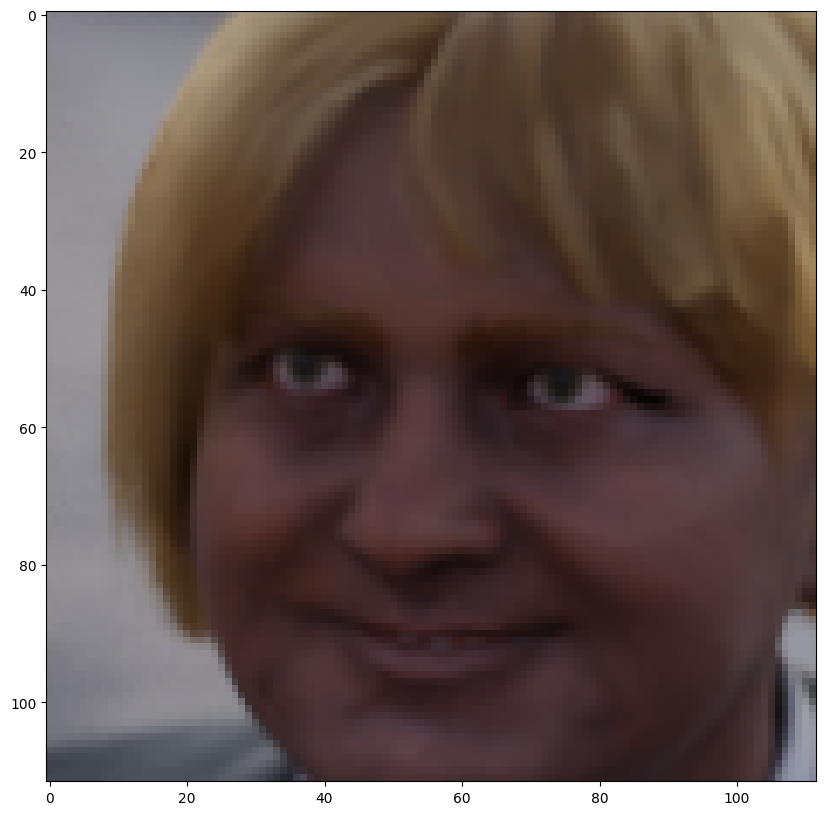

In [323]:
image_dir = dataset.data[dataset.data["type"] == "validation"].iloc[N]['dir']
image = Image.open(image_dir)
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 1, 1)
plt.imshow(image)


In [324]:
knn.kneighbors(dataset.data[dataset.data["type"] == "validation"].iloc[N]["vector"].unsqueeze(0),
               n_neighbors=3, return_distance=True)[1]


array([[742, 295, 474]])

In [325]:
nearest_objs = dataset.data[dataset.data["type"] == "data"].iloc[ knn.kneighbors(dataset.data[dataset.data["type"] == "validation"].iloc[N]["vector"].unsqueeze(0),
               n_neighbors=3, return_distance=True)[1][0]
]
nearest_objs

,dir,person_label,vector,type
928,small_validation/100309/3.png,100309,"[tensor(0.4096), tensor(0.0662), tensor(0.9848...",data
369,small_validation/100203/0.png,100203,"[tensor(0.3285), tensor(0.1263), tensor(0.6745...",data
593,small_validation/100368/3.png,100368,"[tensor(0.1468), tensor(0.1073), tensor(0.2633...",data


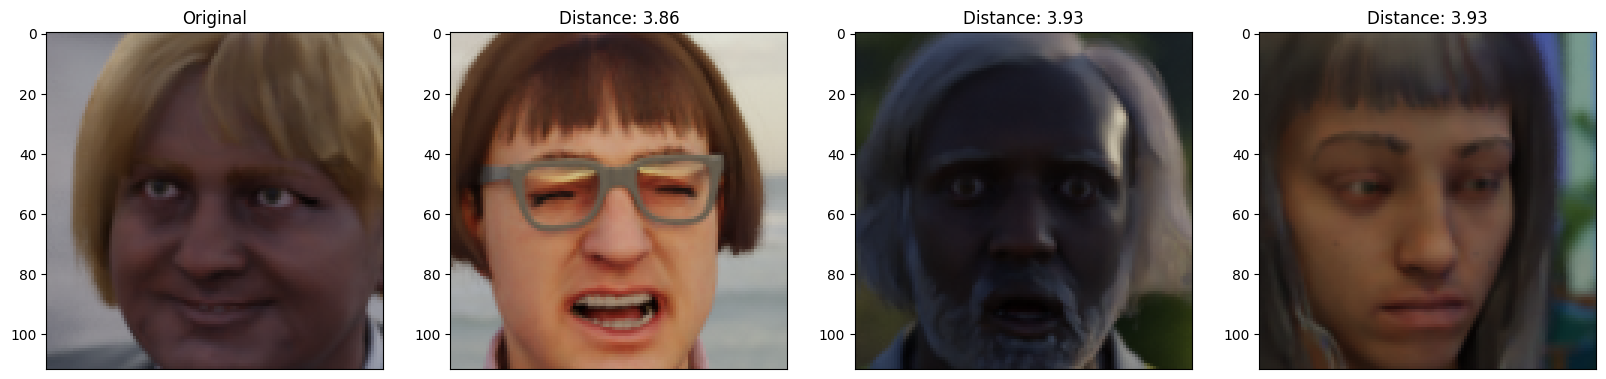

In [326]:
obj_dirs = nearest_objs["dir"].tolist()
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
image_dir = dataset.data[dataset.data["type"] == "validation"].iloc[N]['dir']
image = Image.open(image_dir)
axs[0].imshow(image)
axs[0].set_title("Original")
axs[0].grid(False)
axs[0].set_xticks([])
distances = knn.kneighbors(dataset.data[dataset.data["type"] == "validation"].iloc[N]["vector"].unsqueeze(0),
               n_neighbors=4, return_distance=True)[0][0]
for i, obj_dir in enumerate(obj_dirs):
    image = Image.open(obj_dir)
    axs[i+1].imshow(image)
    # remove grid lines and ticks
    axs[i+1].grid(False)
    axs[i+1].set_xticks([])
    axs[i+1].set_title(f"Distance: {distances[i]:.2f}")


In [327]:
distances = knn.kneighbors(dataset.data[dataset.data["type"] == "validation"].iloc[N]["vector"].unsqueeze(0),
               n_neighbors=4, return_distance=True)[0]
distances

array([[3.85863991, 3.92741532, 3.93013802, 3.98483178]])

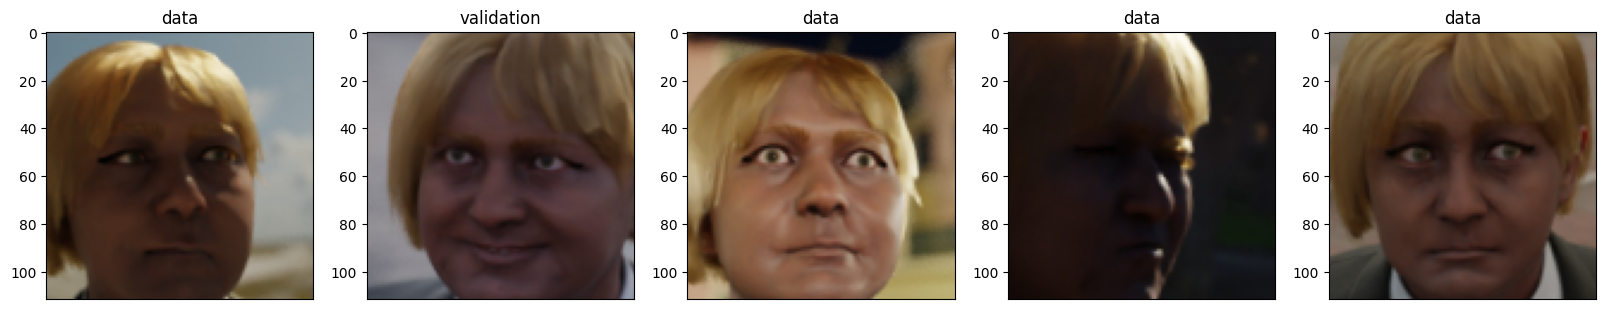

In [328]:
dirs = dataset.data[dataset.data["person_label"] == person]["dir"].tolist()
type = dataset.data[dataset.data["person_label"] == person]["type"].tolist()
fig, axs = plt.subplots(nrows=1, ncols=len(dirs), figsize=(20, 5))
for i, obj_dir in enumerate(dirs):
    image = Image.open(obj_dir)
    axs[i].imshow(image)
    axs[i].grid(False)
    axs[i].set_xticks([])
    axs[i].set_title(f"{type[i]}")

## Кластеризация

In [197]:
data = pd.read_csv("fairface_label_train.csv")
data["vector"] = None
data

,file,age,gender,race,service_test,vector
0,train/1.jpg,50-59,Male,East Asian,True,None
1,train/2.jpg,30-39,Female,Indian,False,None
2,train/3.jpg,3-9,Female,Black,False,None
3,train/4.jpg,20-29,Female,Indian,True,None
4,train/5.jpg,20-29,Female,Indian,True,None
...,...,...,...,...,...,...
86739,train/86740.jpg,20-29,Male,Indian,True,None
86740,train/86741.jpg,10-19,Male,Indian,True,None
86741,train/86742.jpg,more than 70,Female,Indian,True,None
86742,train/86743.jpg,10-19,Female,Black,True,None


In [244]:
data = dataset_trained.data
data = data.rename(columns={"dir":"file"})
persons = [f"100{num}" for num in [143, 152, 157, 158, 200, 266, 269, 287, 345]]
ind = list(data[data["person_label"].isin(persons)].index)

In [245]:
for i, row in tqdm(data.iterrows(), total=len(data)):
    model.eval()
    with torch.no_grad():
        image = Image.open(row["file"])
        if image.mode != "RGB":
            image = image.convert("RGB")
        # image = image.resize((112, 112))
        image = PIL2torch(image)
        image = image.unsqueeze(0)
        image = image.to(device)
        vector = model(image).to("cpu")
        data.at[i, "vector"] = vector

  0%|          | 0/15050 [00:00<?, ?it/s]

In [246]:
data["vector"] =  data["vector"].apply(lambda x: torch.nn.functional.normalize(x[0], p=2, dim=0))

In [247]:
data

,file,person_label,vector,type
0,validation/102068/1.png,102068,"[tensor(-0.1264), tensor(0.0239), tensor(-0.01...",data
1,validation/102068/4.png,102068,"[tensor(-0.1158), tensor(0.0353), tensor(-0.02...",validation
2,validation/102068/2.png,102068,"[tensor(-0.0906), tensor(0.0595), tensor(-0.05...",data
3,validation/102068/3.png,102068,"[tensor(-0.0586), tensor(0.0856), tensor(-0.08...",data
4,validation/102068/0.png,102068,"[tensor(-0.1083), tensor(0.0431), tensor(-0.03...",data
...,...,...,...,...
15045,validation/101584/1.png,101584,"[tensor(-0.0258), tensor(0.1073), tensor(-0.10...",data
15046,validation/101584/4.png,101584,"[tensor(-0.0361), tensor(0.1007), tensor(-0.10...",validation
15047,validation/101584/2.png,101584,"[tensor(-0.0327), tensor(0.1031), tensor(-0.10...",data
15048,validation/101584/3.png,101584,"[tensor(-0.0291), tensor(0.1054), tensor(-0.10...",data


In [248]:
X = torch.stack(
    data["vector"].tolist()
)
X.shape

torch.Size([15050, 128])

In [249]:
n = 2
N = len(data)
X_emb = TSNE(n_components=n).fit_transform(X[:N])

In [250]:
X_emb

array([[-46.32013  ,  48.38688  ],
       [-70.62354  ,  64.17185  ],
       [-43.377705 ,  14.507225 ],
       ...,
       [ -6.9541774, -67.85107  ],
       [-23.581623 , -96.82557  ],
       [-25.887566 , -62.96933  ]], dtype=float32)

In [261]:
colors = data["person_label"][0:N].tolist()

In [262]:
ind = np.random.choice(range(N), size=10000)
if n == 3:
    embed = pd.DataFrame({"x":[X_emb[i][0] for i in ind],
                     "y":[X_emb[i][1] for i in ind],
                      "z":[X_emb[i][2] for i in ind],
                     "c": [colors[i] for i in ind]
                     })
else:
    embed = pd.DataFrame({"x":[X_emb[i][0] for i in ind],
                     "y":[X_emb[i][1] for i in ind],
                     "c": [colors[i] for i in ind]
                     })

In [263]:
# plotly scatter embed dataframe
import plotly.express as px
d = embed.iloc[:20]
if n == 3:
    fig = px.scatter_3d(d, x='x', y='y', z='z', color='c')
else:
    fig = px.scatter(d, x='x', y='y', color='c')
fig.show()